# Experiment: GSM8K Accuracy with Dynamic Temperature (Fixed)

**Goal:** Compare accuracy on GSM8K with:
1. T = T_base (no correction) - clean model
2. T = T_base (no correction) - noisy model  
3. T = T* constant - noisy model
4. T = T*(t) dynamic - noisy model

**Fix:** Each method runs independently with fresh seed per example.

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import re
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("Imports loaded!")

Imports loaded!


In [2]:
# ============================================================
# LOAD MODEL
# ============================================================

MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
T_BASE = 0.8

print(f"Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,
    device_map="auto"
)
model.eval()

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Model loaded on {model.device}")
print(f"T_base = {T_BASE}")

Loading deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Model loaded on cuda:0
T_base = 0.8


In [3]:
# ============================================================
# LOAD GSM8K
# ============================================================

gsm8k = load_dataset('openai/gsm8k', 'main', split='test')
print(f"GSM8K loaded: {len(gsm8k)} examples")

NUM_EXAMPLES = 20
test_examples = [gsm8k[i] for i in range(NUM_EXAMPLES)]
print(f"Using {NUM_EXAMPLES} examples")

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

GSM8K loaded: 1319 examples
Using 20 examples


In [ ]:
# ============================================================
# UTILITY FUNCTIONS
# ============================================================

def extract_answer(text):
    """Extract numerical answer from model response."""
    boxed = re.findall(r'\\boxed\{([^}]+)\}', text)
    if boxed:
        nums = re.findall(r'-?[\d,]+\.?\d*', boxed[-1].replace(',', ''))
        if nums:
            return nums[-1]
    
    patterns = [
        r'answer is[:\s]*\$?(-?[\d,]+\.?\d*)',
        r'=\s*\$?(-?[\d,]+\.?\d*)\s*$',
        r'\$(-?[\d,]+\.?\d*)\s*$',
    ]
    for pattern in patterns:
        match = re.search(pattern, text.replace(',', ''), re.IGNORECASE | re.MULTILINE)
        if match:
            return match.group(1)
    
    nums = re.findall(r'-?[\d,]+\.?\d*', text.replace(',', ''))
    return nums[-1] if nums else ''


def extract_ground_truth(answer_text):
    match = re.search(r'####\s*(-?[\d,]+\.?\d*)', answer_text.replace(',', ''))
    return match.group(1) if match else ''


def check_answer(pred, truth):
    if not pred or not truth:
        return False
    try:
        return abs(float(pred) - float(truth)) < 1e-5
    except:
        return pred.strip() == truth.strip()

print("Utilities ready!")

Utilities ready!


In [5]:
# ============================================================
# NOISE INJECTION
# ============================================================

def add_activation_noise(model, noise_scale):
    """Add noise to all linear layer activations."""
    handles = []
    
    def make_hook(scale):
        def hook(module, args):
            if len(args) > 0 and args[0] is not None:
                inp = args[0]
                noise = torch.randn_like(inp) * scale * inp.std()
                return (inp + noise,) + args[1:]
            return None
        return hook
    
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            h = module.register_forward_pre_hook(make_hook(noise_scale))
            handles.append(h)
    
    return handles


def remove_hooks(handles):
    for h in handles:
        h.remove()

print("Noise injection ready!")

Noise injection ready!


In [6]:
# ============================================================
# UNIFIED GENERATION FUNCTION
# ============================================================

def generate(model, tokenizer, prompt, max_tokens, T_base, noise_scale, temp_mode='fixed', alpha_func=None):
    """
    Unified generation function.
    
    temp_mode:
      - 'fixed': use T_base
      - 'const': use T_base * (1 + mean_alpha)  
      - 'dynamic': use T_base * (1 + alpha_func(t))
    """
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    input_ids = inputs.input_ids.clone()
    prompt_len = input_ids.shape[1]
    
    if noise_scale > 0:
        noise_handles = add_activation_noise(model, noise_scale)
    else:
        noise_handles = []
    
    try:
        for step in range(max_tokens):
            with torch.no_grad():
                outputs = model(input_ids)
            logits = outputs.logits[0, -1, :]
            
            # Compute temperature based on mode
            if temp_mode == 'fixed':
                T = T_base
            elif temp_mode == 'const':
                T = T_base * (1 + alpha_func(0))  # alpha_func returns mean_alpha for const
            elif temp_mode == 'dynamic':
                T = T_base * (1 + alpha_func(step))
            else:
                T = T_base
            
            probs = F.softmax(logits / T, dim=-1)
            next_token = torch.multinomial(probs, 1)
            
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)
            
            if next_token.item() == tokenizer.eos_token_id:
                break
    finally:
        if noise_handles:
            remove_hooks(noise_handles)
    
    response = tokenizer.decode(input_ids[0, prompt_len:], skip_special_tokens=True)
    return response

print("Generation function ready!")

Generation function ready!


In [7]:
# ============================================================
# MEASURE α(t) DECAY
# ============================================================

NOISE_SCALE = 0.01

print(f"Measuring α decay with noise scale σ = {NOISE_SCALE}...")

sample_prompt = "Solve step by step: A store has 50 apples. They sell 20 and receive 30 more. How many now?"
inputs = tokenizer(sample_prompt, return_tensors='pt').to(model.device)

with torch.no_grad():
    clean_outputs = model(inputs.input_ids)
clean_logits = clean_outputs.logits[0]

num_samples = 10
seq_len = clean_logits.shape[0]
all_alphas = [[] for _ in range(seq_len)]

for _ in range(num_samples):
    handles = add_activation_noise(model, NOISE_SCALE)
    with torch.no_grad():
        noisy_outputs = model(inputs.input_ids)
    remove_hooks(handles)
    noisy_logits = noisy_outputs.logits[0]
    
    for pos in range(seq_len):
        diff = noisy_logits[pos] - clean_logits[pos]
        tau_sq = clean_logits[pos].var().item()
        sigma_sq = diff.var().item()
        alpha = sigma_sq / tau_sq if tau_sq > 0 else 0
        all_alphas[pos].append(alpha)

alpha_by_position = [np.mean(a) for a in all_alphas]
mean_alpha = np.mean(alpha_by_position)

print(f"Mean α = {mean_alpha:.4f}")
print(f"α range: [{np.min(alpha_by_position):.4f}, {np.max(alpha_by_position):.4f}]")

Measuring α decay with noise scale σ = 0.01...
Mean α = 0.0106
α range: [0.0002, 0.0505]


In [8]:
# ============================================================
# FIT α(t) FUNCTION
# ============================================================

from scipy.optimize import curve_fit

def exp_decay(t, a, b, c):
    return a * np.exp(-b * t) + c

positions = np.arange(len(alpha_by_position))
alpha_arr = np.array(alpha_by_position)

try:
    popt, _ = curve_fit(exp_decay, positions, alpha_arr, p0=[0.1, 0.01, 0.05], maxfev=5000)
    a, b, c = popt
    print(f"Fitted: α(t) = {a:.4f} × exp(-{b:.4f}×t) + {c:.4f}")
    
    def alpha_dynamic(t):
        return a * np.exp(-b * t) + c
    
    fit_success = True
except Exception as e:
    print(f"Fitting failed: {e}, using constant")
    def alpha_dynamic(t):
        return mean_alpha
    fit_success = False

def alpha_const(t):
    return mean_alpha

T_CONST = T_BASE * (1 + mean_alpha)
print(f"\nT_base = {T_BASE}")
print(f"T* constant = {T_CONST:.4f}")
print(f"T* dynamic at t=0: {T_BASE * (1 + alpha_dynamic(0)):.4f}")
print(f"T* dynamic at t=100: {T_BASE * (1 + alpha_dynamic(100)):.4f}")

Fitted: α(t) = 0.0043 × exp(-0.0343×t) + 0.0079

T_base = 0.8
T* constant = 0.8085
T* dynamic at t=0: 0.8098
T* dynamic at t=100: 0.8064


In [9]:
# ============================================================
# EVALUATE - RUN EACH METHOD SEPARATELY
# ============================================================

MAX_TOKENS = 1024

# Prepare prompts
prompts = []
ground_truths = []
for ex in test_examples:
    messages = [{"role": "user", "content": f"Solve this step by step:\n{ex['question']}"}]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    prompts.append(prompt)
    ground_truths.append(extract_ground_truth(ex['answer']))

print(f"Prepared {len(prompts)} prompts")

Prepared 20 prompts


In [10]:
# ============================================================
# 1. CLEAN MODEL WITH T_BASE
# ============================================================

print("1. Evaluating: Clean + T_base...")
correct_clean = 0

for i, (prompt, truth) in enumerate(tqdm(zip(prompts, ground_truths), total=len(prompts))):
    set_seed(1000 + i)
    response = generate(model, tokenizer, prompt, MAX_TOKENS, T_BASE, noise_scale=0.0, temp_mode='fixed')
    pred = extract_answer(response)
    if check_answer(pred, truth):
        correct_clean += 1

acc_clean = correct_clean / len(prompts) * 100
print(f"Clean + T_base: {correct_clean}/{len(prompts)} = {acc_clean:.1f}%")

1. Evaluating: Clean + T_base...


100%|██████████| 20/20 [12:13<00:00, 36.70s/it]

Clean + T_base: 12/20 = 60.0%


In [11]:
# ============================================================
# 2. NOISY MODEL WITH T_BASE (NO CORRECTION)
# ============================================================

print("2. Evaluating: Noisy + T_base (no correction)...")
correct_noisy_base = 0

for i, (prompt, truth) in enumerate(tqdm(zip(prompts, ground_truths), total=len(prompts))):
    set_seed(2000 + i)
    response = generate(model, tokenizer, prompt, MAX_TOKENS, T_BASE, noise_scale=NOISE_SCALE, temp_mode='fixed')
    pred = extract_answer(response)
    if check_answer(pred, truth):
        correct_noisy_base += 1

acc_noisy_base = correct_noisy_base / len(prompts) * 100
print(f"Noisy + T_base: {correct_noisy_base}/{len(prompts)} = {acc_noisy_base:.1f}%")

2. Evaluating: Noisy + T_base (no correction)...


100%|██████████| 20/20 [20:05<00:00, 60.25s/it]

Noisy + T_base: 10/20 = 50.0%


In [12]:
# ============================================================
# 3. NOISY MODEL WITH CONSTANT T*
# ============================================================

print("3. Evaluating: Noisy + T* constant...")
correct_noisy_const = 0

for i, (prompt, truth) in enumerate(tqdm(zip(prompts, ground_truths), total=len(prompts))):
    set_seed(3000 + i)
    response = generate(model, tokenizer, prompt, MAX_TOKENS, T_BASE, noise_scale=NOISE_SCALE, 
                       temp_mode='const', alpha_func=alpha_const)
    pred = extract_answer(response)
    if check_answer(pred, truth):
        correct_noisy_const += 1

acc_noisy_const = correct_noisy_const / len(prompts) * 100
print(f"Noisy + T* const: {correct_noisy_const}/{len(prompts)} = {acc_noisy_const:.1f}%")

3. Evaluating: Noisy + T* constant...


100%|██████████| 20/20 [17:56<00:00, 53.83s/it]

Noisy + T* const: 11/20 = 55.0%


In [13]:
# ============================================================
# 4. NOISY MODEL WITH DYNAMIC T*(t)
# ============================================================

print("4. Evaluating: Noisy + T*(t) dynamic...")
correct_noisy_dynamic = 0

for i, (prompt, truth) in enumerate(tqdm(zip(prompts, ground_truths), total=len(prompts))):
    set_seed(4000 + i)
    response = generate(model, tokenizer, prompt, MAX_TOKENS, T_BASE, noise_scale=NOISE_SCALE,
                       temp_mode='dynamic', alpha_func=alpha_dynamic)
    pred = extract_answer(response)
    if check_answer(pred, truth):
        correct_noisy_dynamic += 1

acc_noisy_dynamic = correct_noisy_dynamic / len(prompts) * 100
print(f"Noisy + T*(t) dynamic: {correct_noisy_dynamic}/{len(prompts)} = {acc_noisy_dynamic:.1f}%")

4. Evaluating: Noisy + T*(t) dynamic...


100%|██████████| 20/20 [19:17<00:00, 57.86s/it]

Noisy + T*(t) dynamic: 13/20 = 65.0%


In [14]:
# ============================================================
# FINAL RESULTS
# ============================================================

print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
print(f"Model: {MODEL_NAME}")
print(f"Noise scale: {NOISE_SCALE}")
print(f"T_base: {T_BASE}")
print(f"T* constant: {T_CONST:.4f}")
print(f"Examples: {NUM_EXAMPLES}")
print()

print(f"{'Setting':<30} {'Accuracy':<15}")
print("-"*45)
print(f"{'1. Clean + T_base':<30} {acc_clean:.1f}%")
print(f"{'2. Noisy + T_base':<30} {acc_noisy_base:.1f}%")
print(f"{'3. Noisy + T* constant':<30} {acc_noisy_const:.1f}%")
print(f"{'4. Noisy + T*(t) dynamic':<30} {acc_noisy_dynamic:.1f}%")

# Recovery calculation
loss = acc_clean - acc_noisy_base
if loss > 0:
    recovery_const = (acc_noisy_const - acc_noisy_base) / loss * 100
    recovery_dynamic = (acc_noisy_dynamic - acc_noisy_base) / loss * 100
else:
    recovery_const = 0
    recovery_dynamic = 0

print()
print(f"Accuracy loss from noise: {loss:.1f}%")
print(f"Recovery with T* constant: {recovery_const:.1f}%")
print(f"Recovery with T* dynamic: {recovery_dynamic:.1f}%")


FINAL RESULTS
Model: deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B
Noise scale: 0.01
T_base: 0.8
T* constant: 0.8085
Examples: 20

Setting                        Accuracy       
---------------------------------------------
1. Clean + T_base              60.0%
2. Noisy + T_base              50.0%
3. Noisy + T* constant         55.0%
4. Noisy + T*(t) dynamic       65.0%

Accuracy loss from noise: 10.0%
Recovery with T* constant: 50.0%
Recovery with T* dynamic: 150.0%


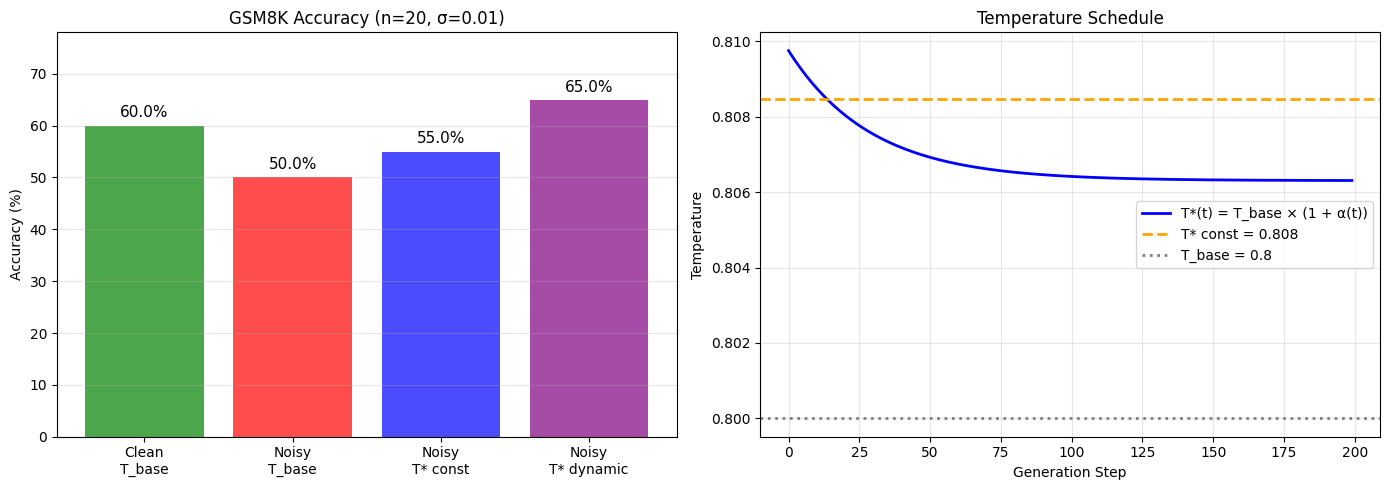

In [15]:
# ============================================================
# PLOT
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Accuracy comparison
ax1 = axes[0]
names = ['Clean\nT_base', 'Noisy\nT_base', 'Noisy\nT* const', 'Noisy\nT* dynamic']
accs = [acc_clean, acc_noisy_base, acc_noisy_const, acc_noisy_dynamic]
colors = ['green', 'red', 'blue', 'purple']
bars = ax1.bar(names, accs, color=colors, alpha=0.7)
ax1.set_ylabel('Accuracy (%)')
ax1.set_title(f'GSM8K Accuracy (n={NUM_EXAMPLES}, σ={NOISE_SCALE})')
ax1.set_ylim(0, max(accs) * 1.2)
for bar, acc in zip(bars, accs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Right: Dynamic temperature schedule
ax2 = axes[1]
t_range = np.arange(0, 200)
T_star_curve = [T_BASE * (1 + alpha_dynamic(t)) for t in t_range]
ax2.plot(t_range, T_star_curve, 'b-', linewidth=2, label='T*(t) = T_base × (1 + α(t))')
ax2.axhline(y=T_CONST, color='orange', linestyle='--', linewidth=2, label=f'T* const = {T_CONST:.3f}')
ax2.axhline(y=T_BASE, color='gray', linestyle=':', linewidth=2, label=f'T_base = {T_BASE}')
ax2.set_xlabel('Generation Step')
ax2.set_ylabel('Temperature')
ax2.set_title('Temperature Schedule')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gsm8k_accuracy_fixed.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# ============================================================
# SUMMARY
# ============================================================

print("="*70)
print("SUMMARY")
print("="*70)

winner = 'T* dynamic' if acc_noisy_dynamic > acc_noisy_const else 'T* constant'
if acc_noisy_dynamic == acc_noisy_const:
    winner = 'Tie'

print(f"""
Formula: T*(t) = T_base × (1 + α(t))

Results on GSM8K ({NUM_EXAMPLES} examples):
  - Noise causes {loss:.1f}% accuracy drop
  - T* constant recovers {recovery_const:.1f}% of lost accuracy  
  - T* dynamic recovers {recovery_dynamic:.1f}% of lost accuracy
  
Winner: {winner}

Note: Different seeds used for each method to ensure independent evaluation.
""")

SUMMARY

Formula: T*(t) = T_base × (1 + α(t))

Results on GSM8K (20 examples):
  - Noise causes 10.0% accuracy drop
  - T* constant recovers 50.0% of lost accuracy  
  - T* dynamic recovers 150.0% of lost accuracy
  
Winner: T* dynamic

Note: Different seeds used for each method to ensure independent evaluation.

